# <i> <center> <b>  Network Anomaly Detection ML Modeling

In [2]:
%%capture
!pip install category_encoders
!pip install imbalanced-learn
!pip install matplotlib

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

### <b> <i> Data Processing : EDA 

In [4]:
df=pd.read_csv('NAD.csv')
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [5]:
df.isnull().sum()

duration                  0
protocoltype              0
service                   0
flag                      0
srcbytes                  0
dstbytes                  0
land                      0
wrongfragment             0
urgent                    0
hot                       0
numfailedlogins           0
loggedin                  0
numcompromised            0
rootshell                 0
suattempted               0
numroot                   0
numfilecreations          0
numshells                 0
numaccessfiles            0
numoutboundcmds           0
ishostlogin               0
isguestlogin              0
count                     0
srvcount                  0
serrorrate                0
srvserrorrate             0
rerrorrate                0
srvrerrorrate             0
samesrvrate               0
diffsrvrate               0
srvdiffhostrate           0
dsthostcount              0
dsthostsrvcount           0
dsthostsamesrvrate        0
dsthostdiffsrvrate        0
dsthostsamesrcportra

In [6]:
# Checking for duplicates
duplicates = df.duplicated().sum()
print(f'Duplicates: {duplicates}')

# Removing duplicates
df = df.drop_duplicates()

Duplicates: 0


In [7]:
# Converting categorical columns to lowercase
df['protocoltype'] = df['protocoltype'].str.lower()
df['service'] = df['service'].str.lower()
df['flag'] = df['flag'].str.lower()

#### <i> Outlier Detection: </i>

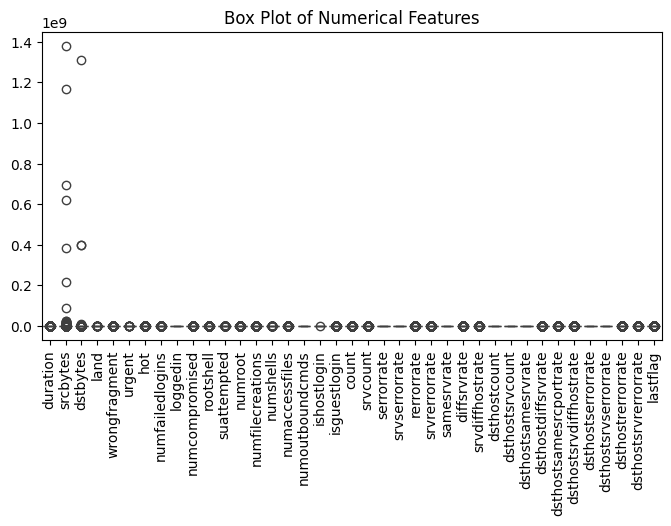

In [8]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df.select_dtypes(include=['number']))  # Plot box plots only for numerical columns
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.title('Box Plot of Numerical Features')
plt.show()

In [9]:
# Selecting only numeric columns
numeric_df = df.select_dtypes(include=[np.number])
# Step 1: Z-Score Method
# Calculating Z-Scores for each column
z_scores = stats.zscore(numeric_df)
z_scores_df = pd.DataFrame(z_scores, columns=numeric_df.columns)
z_threshold = 3.5
# Identifying outliers based on Z-scores
z_outliers = (z_scores_df.abs() > z_threshold)
z_outlier_indices = z_outliers[z_outliers.any(axis=1)].index
# Step 2: IQR Method
# Calculating Q1 (25th percentile) and Q3 (75th percentile)
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
iqr_threshold = 1.5 
iqr_outliers = ((numeric_df < (Q1 - iqr_threshold * IQR)) | (numeric_df > (Q3 + iqr_threshold * IQR)))
iqr_outlier_indices = iqr_outliers[iqr_outliers.any(axis=1)].index
# Finding common outliers
common_outlier_indices = z_outlier_indices.intersection(iqr_outlier_indices)
# Printing the size of common outliers and original data
print("Common outliers size identified by both methods and original data size :")
print(common_outlier_indices.shape, df.shape)
# Dropping the common outliers from the DataFrame
df_cleaned = df.drop(index=common_outlier_indices, errors='ignore')

df_cleaned.reset_index(drop=True, inplace=True)
# Verifying the size after dropping outliers
print("Data size after dropping outliers: ")
print(df_cleaned.shape)

Common outliers size identified by both methods and original data size :
(16570,) (125973, 43)
Data size after dropping outliers: 
(109403, 43)


In [10]:
df=df_cleaned

#### <i>Feature Engineering 

In [11]:
df['total_bytes'] = df['srcbytes'] + df['dstbytes']
df['byte_ratio'] = df['srcbytes'] / (df['dstbytes'] + 1)

In [12]:
df.drop(columns=['srcbytes', 'dstbytes'], inplace=True)

In [13]:
df['wrongfragment'].value_counts()

wrongfragment
0    109403
Name: count, dtype: int64

In [14]:
df.drop(columns=['wrongfragment'], inplace=True)

In [15]:
df.shape

(109403, 42)

In [16]:
df['urgent'].value_counts()
df.drop(columns=['urgent'], inplace=True)

In [17]:
df['combined_serror_rerror_rate'] = (df['serrorrate'] + df['rerrorrate'] ) / 2
df['combined_srv_serror_rerror_rate'] = (df['srvserrorrate'] + df['srvrerrorrate'] ) / 2

In [18]:
df['ratio_samesrvrate_diffsrvrate'] = df['samesrvrate'] / (df['diffsrvrate'] + 1e-6)

In [19]:
df['service_host_distribution_ratio'] = df['samesrvrate'] / (df['srvdiffhostrate'] + 1e-6)

In [20]:
df['combined_dsthostserrorrate_dsthostrerrorrate'] = df['dsthostserrorrate'] + (df['dsthostrerrorrate'] + 1e-6)

In [21]:
df['combined_dsthostsrvserrorrate_dsthostsrvrerrorrate'] = df['dsthostsrvserrorrate'] +  (df['dsthostsrvrerrorrate'] + 1e-6) 

In [22]:
 df.drop(columns=['serrorrate','rerrorrate','srvserrorrate','srvrerrorrate',
                    'samesrvrate','diffsrvrate','srvdiffhostrate','dsthostserrorrate',
                  'dsthostrerrorrate','dsthostsrvserrorrate','dsthostsrvrerrorrate'],inplace=True)

In [23]:
df.columns

Index(['duration', 'protocoltype', 'service', 'flag', 'land', 'hot',
       'numfailedlogins', 'loggedin', 'numcompromised', 'rootshell',
       'suattempted', 'numroot', 'numfilecreations', 'numshells',
       'numaccessfiles', 'numoutboundcmds', 'ishostlogin', 'isguestlogin',
       'count', 'srvcount', 'dsthostcount', 'dsthostsrvcount',
       'dsthostsamesrvrate', 'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'attack', 'lastflag', 'total_bytes',
       'byte_ratio', 'combined_serror_rerror_rate',
       'combined_srv_serror_rerror_rate', 'ratio_samesrvrate_diffsrvrate',
       'service_host_distribution_ratio',
       'combined_dsthostserrorrate_dsthostrerrorrate',
       'combined_dsthostsrvserrorrate_dsthostsrvrerrorrate'],
      dtype='object')

In [24]:
df['service'].unique()

array(['ftp_data', 'other', 'private', 'http', 'remote_job', 'name',
       'netbios_ns', 'mtp', 'finger', 'domain_u', 'supdup', 'uucp_path',
       'z39_50', 'smtp', 'csnet_ns', 'eco_i', 'uucp', 'netbios_dgm',
       'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap', 'ecr_i', 'telnet',
       'vmnet', 'systat', 'http_443', 'efs', 'whois', 'gopher', 'imap4',
       'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login', 'kshell',
       'time', 'sql_net', 'hostnames', 'exec', 'ntp_u', 'discard', 'nntp',
       'courier', 'ctf', 'ssh', 'daytime', 'shell', 'netstat', 'pop_3',
       'nnsp', 'pop_2', 'printer', 'irc', 'red_i', 'netbios_ssn', 'rje',
       'x11', 'urh_i', 'tim_i'], dtype=object)

### <b>  <i>  Data Transformation:

<i> Encoded the 'attack' column using LabelEncoder, replaced it with the new 'attack_encoded' column, and dropped the original 'attack' column.

In [25]:
label_encoder = LabelEncoder()
df['attack_encoded'] = label_encoder.fit_transform(df['attack'])
df.drop('attack', axis=1, inplace=True)
df.head()

,duration,protocoltype,service,flag,land,hot,numfailedlogins,loggedin,numcompromised,rootshell,...,lastflag,total_bytes,byte_ratio,combined_serror_rerror_rate,combined_srv_serror_rerror_rate,ratio_samesrvrate_diffsrvrate,service_host_distribution_ratio,combined_dsthostserrorrate_dsthostrerrorrate,combined_dsthostsrvserrorrate_dsthostsrvrerrorrate,attack_encoded
0,0,tcp,ftp_data,sf,0,0,0,0,0,0,...,20,491,491.000000,0.0,0.0,1000000.000000,1000000.000000,0.050001,0.000001,8
1,0,udp,other,sf,0,0,0,0,0,0,...,15,146,146.000000,0.0,0.0,0.533330,80000.000000,0.000001,0.000001,8
2,0,tcp,private,s0,0,0,0,0,0,0,...,19,0,0.000000,0.5,0.5,0.714276,50000.000000,1.000001,1.000001,6
3,0,tcp,http,sf,0,0,0,1,0,0,...,21,8385,0.028452,0.1,0.1,1000000.000000,1000000.000000,0.030001,0.020001,8
4,0,tcp,http,sf,0,0,0,1,0,0,...,21,619,0.472684,0.0,0.0,1000000.000000,11.110988,0.000001,0.000001,8


<i> Selected the first three categorical columns, encoded them using CatBoostEncoder, and replaced the original columns with the encoded features.

In [26]:
categorical_columns =df.select_dtypes(include=['object', 'category']).columns.tolist()
# Initializing CatBoostEncoder
catboost_encoder =ce.CatBoostEncoder(cols=categorical_columns[:3])
# Fiting and transforming the categorical features
df_encoded_features =catboost_encoder.fit_transform(df[categorical_columns[:3]],df['attack_encoded'])
df[categorical_columns[:3]]=df_encoded_features

In [27]:
df[categorical_columns[:3]].head()

,protocoltype,service,flag
0,7.255624,7.255624,7.255624
1,7.255624,7.255624,7.627812
2,7.627812,7.255624,7.255624
3,7.085208,7.255624,7.751875
4,7.313906,7.627812,7.813906


In [28]:
df.head()

,duration,protocoltype,service,flag,land,hot,numfailedlogins,loggedin,numcompromised,rootshell,...,lastflag,total_bytes,byte_ratio,combined_serror_rerror_rate,combined_srv_serror_rerror_rate,ratio_samesrvrate_diffsrvrate,service_host_distribution_ratio,combined_dsthostserrorrate_dsthostrerrorrate,combined_dsthostsrvserrorrate_dsthostsrvrerrorrate,attack_encoded
0,0,7.255624,7.255624,7.255624,0,0,0,0,0,0,...,20,491,491.000000,0.0,0.0,1000000.000000,1000000.000000,0.050001,0.000001,8
1,0,7.255624,7.255624,7.627812,0,0,0,0,0,0,...,15,146,146.000000,0.0,0.0,0.533330,80000.000000,0.000001,0.000001,8
2,0,7.627812,7.255624,7.255624,0,0,0,0,0,0,...,19,0,0.000000,0.5,0.5,0.714276,50000.000000,1.000001,1.000001,6
3,0,7.085208,7.255624,7.751875,0,0,0,1,0,0,...,21,8385,0.028452,0.1,0.1,1000000.000000,1000000.000000,0.030001,0.020001,8
4,0,7.313906,7.627812,7.813906,0,0,0,1,0,0,...,21,619,0.472684,0.0,0.0,1000000.000000,11.110988,0.000001,0.000001,8


In [29]:
X = df.drop(columns=['attack_encoded'])
y = df['attack_encoded']

<i> Separated the features (X) by dropping 'attack_encoded' and set 'attack_encoded' as the target variable (y).

### <b> <i>Filtering Rare Classes and Updating Features and Target Variable : </i>

In [30]:
threshold = 6
class_counts = df['attack_encoded'].value_counts()

# Finding classes with fewer samples than the threshold
classes_to_remove = class_counts[class_counts < threshold].index

# Droping rows with these classes
df_filtered = df[~df['attack_encoded'].isin(classes_to_remove)]

# Separating features and target
X = df_filtered.drop('attack_encoded', axis=1)
y = df_filtered['attack_encoded']
print("Class distribution after filtering:", Counter(y))

Class distribution after filtering: Counter({8: 62739, 6: 41111, 9: 1448, 7: 1148, 10: 1117, 11: 765, 0: 488, 4: 295, 12: 273, 3: 10})


### <b> <i> Splitting Data and Balancing Classes with SMOTE :

In [31]:
# Spliting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X,y=X_resampled, y_resampled
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({8: 43792, 6: 28891, 9: 1011, 7: 811, 10: 774, 11: 542, 0: 359, 12: 197, 4: 190, 3: 8})
After SMOTE: Counter({8: 43792, 6: 43792, 10: 43792, 9: 43792, 4: 43792, 12: 43792, 11: 43792, 0: 43792, 7: 43792, 3: 43792})


<i> Split the dataset into training and test sets, then applied SMOTE to the training data to address class imbalance. The class distribution before and after SMOTE was printed to verify the balancing effect.

### <b> <i> Hyperparameter Tuning and Evaluation of Bagging Classifier with Decision Tree :

In [32]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initializing KFold
stratified_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)  
# Initializing the Decision Tree and Bagging Classifier
decision_tree = DecisionTreeClassifier(random_state=42)
bagging_clf = BaggingClassifier(estimator=decision_tree, random_state=42) 
# Hyperparameter tuning for Bagging
param_grid_bagging = {
    'estimator__max_depth': [None,1, 2, 4, 6, 8, 10],  
    'n_estimators': [10, 100]
}
grid_search_bagging = GridSearchCV(bagging_clf, param_grid_bagging, cv=stratified_kfold, scoring='accuracy')
grid_search_bagging.fit(X_train, y_train)
# Best parameters and cross-validation accuracy for Bagging
print("Best parameters for Bagging:", grid_search_bagging.best_params_)
print("Best cross-validation accuracy for Bagging:", grid_search_bagging.best_score_)
# Testing the best model on the test set
best_bagging_model = grid_search_bagging.best_estimator_
y_pred_bagging = best_bagging_model.predict(X_test)
print("Test accuracy for Bagging:", accuracy_score(y_test, y_pred_bagging))

Best parameters for Bagging: {'estimator__max_depth': None, 'n_estimators': 100}
Best cross-validation accuracy for Bagging: 0.9997802109974425
Test accuracy for Bagging: 0.9998744062842528


<i> Performed hyperparameter tuning on a Bagging Classifier using a Decision Tree as the base estimator, with GridSearchCV and StratifiedKFold cross-validation.

<i> Found the optimal parameters to be {'estimator__max_depth': None, 'n_estimators': 100} and achieved a cross-validation accuracy of 0.99978.

<i> Evaluated the tuned Bagging model on the test set, resulting in a high test accuracy of 0.99987.

### <b><i> Evaluation Metrics for Bagging Classifier with Decision Tree: Precision, Recall, and F1-Score :

In [33]:
y_pred = y_pred_bagging
# Precision, Recall, F1-Score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
# Creating DataFrames
precision_df = pd.DataFrame({'Class': range(len(precision)), 'Precision': precision})
recall_df = pd.DataFrame({'Class': range(len(recall)), 'Recall': recall})
f1_df = pd.DataFrame({'Class': range(len(f1)), 'F1-Score': f1})
# Adding weighted averages to the DataFrames
precision_avg = precision_score(y_test, y_pred, average='weighted')
recall_avg = recall_score(y_test, y_pred, average='weighted')
f1_avg = f1_score(y_test, y_pred, average='weighted')
# Converting weighted averages into DataFrames
precision_avg_df = pd.DataFrame({'Class': ['Weighted Average'], 'Precision': [precision_avg]})
recall_avg_df = pd.DataFrame({'Class': ['Weighted Average'], 'Recall': [recall_avg]})
f1_avg_df = pd.DataFrame({'Class': ['Weighted Average'], 'F1-Score': [f1_avg]})
# Concatenating original DataFrames with the average DataFrames
precision_df = pd.concat([precision_df, precision_avg_df], ignore_index=True)
recall_df = pd.concat([recall_df, recall_avg_df], ignore_index=True)
f1_df = pd.concat([f1_df, f1_avg_df], ignore_index=True)

print("Precision DataFrame:")
print(precision_df)
print("\nRecall DataFrame:")
print(recall_df)
print("\nF1-Score DataFrame:")
print(f1_df)

Precision DataFrame:
               Class  Precision
0                  0   1.000000
1                  1   1.000000
2                  2   0.999437
3                  3   1.000000
4                  4   1.000000
5                  5   0.999772
6                  6   0.999885
7                  7   1.000000
8                  8   0.999886
9                  9   0.999771
10  Weighted Average   0.999874

Recall DataFrame:
               Class    Recall
0                  0  1.000000
1                  1  1.000000
2                  2  1.000000
3                  3  1.000000
4                  4  0.999660
5                  5  0.999317
6                  6  1.000000
7                  7  1.000000
8                  8  1.000000
9                  9  0.999771
10  Weighted Average  0.999874

F1-Score DataFrame:
               Class  F1-Score
0                  0  1.000000
1                  1  1.000000
2                  2  0.999718
3                  3  1.000000
4                  4  0.9998

<i> Precision: The classifier achieved near-perfect precision for most classes, with a weighted average precision of 0.999874.

<i> Recall: The classifier exhibited high recall across all classes, with a weighted average recall of 0.999874.

<i> F1-Score: The F1-scores were very high, with a weighted average F1-score of 0.999874, indicating a strong overall performance.

### <b> <i> Confusion Matrix for Bagging Classifier with Decision Tree :

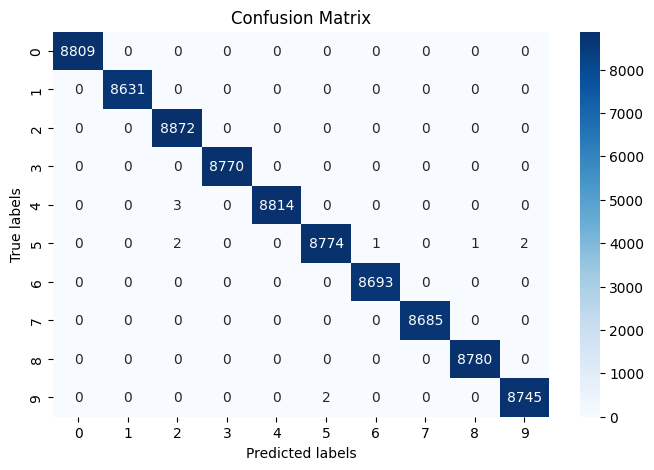

In [34]:
#Ploting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(precision)), yticklabels=range(len(precision)))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### <b> <i> Feature Importances from Bagging Classifier with Decision Tree :

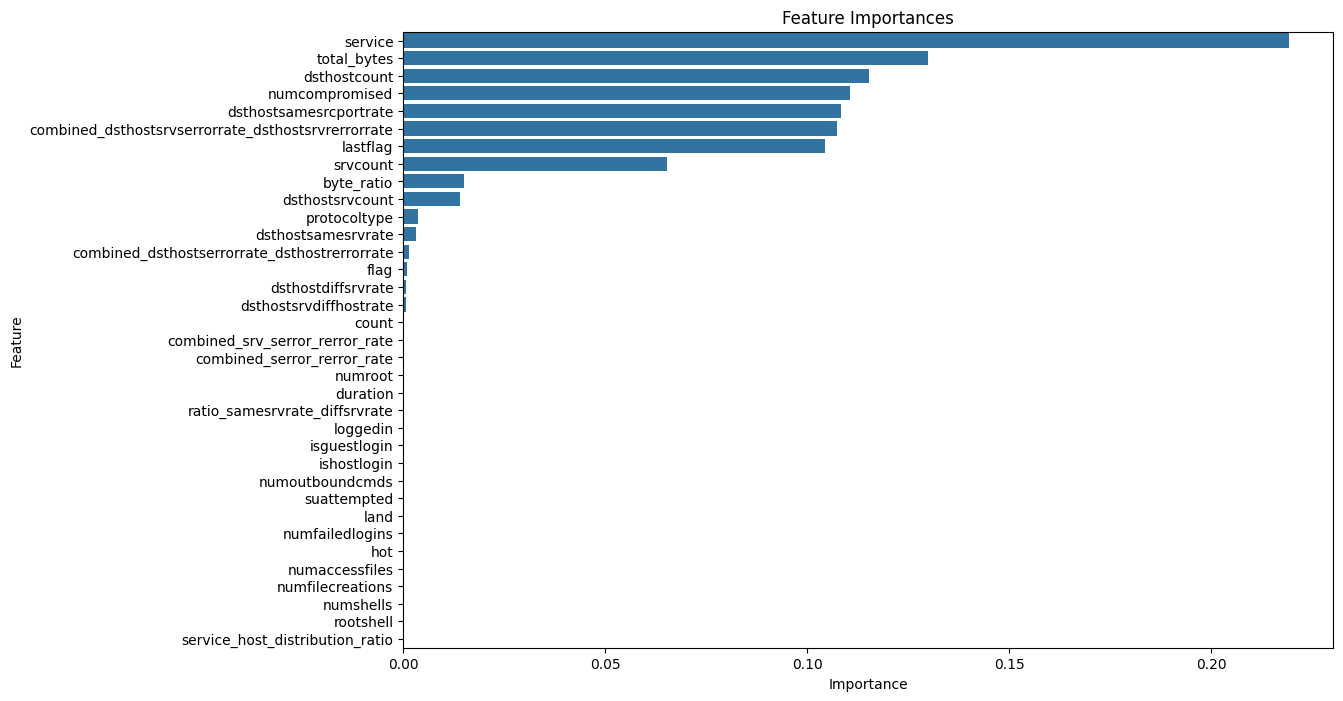

In [35]:
# Extracting feature importances from the best model
feature_importances =best_bagging_model.estimators_[0].feature_importances_
# Creating a DataFrame for plotting
features_df=pd.DataFrame({
    'Feature': X.columns,
'Importance': feature_importances
})
# Sorting the DataFrame by importance
features_df=features_df.sort_values(by='Importance', ascending=False)
# Ploting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

<i>  'service', 'total_bytes', and 'dsthostcount' are the most important features in your model. 

### <b> <i> Gradient Boosting Classifier Hyperparameter Tuning and Evaluation :

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

# Initializing the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)
# Hyperparameters tuning
param_grid_gb ={
    'n_estimators': [10],
    'learning_rate': [0.2],
    'max_depth': [5],
    'subsample': [0.8]
}
# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# GridSearchCV
grid_search_gb = GridSearchCV(gb_clf, param_grid_gb, cv=stratified_kfold, scoring='accuracy', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)
# Best parameters and cross-validation accuracy for Gradient Boosting
print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)
print("Best cross-validation accuracy for Gradient Boosting:", grid_search_gb.best_score_)
# Testing the best model on the test set
best_gb_model = grid_search_gb.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)
print("Test accuracy for Gradient Boosting:", accuracy_score(y_test, y_pred_gb))

Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.8}
Best cross-validation accuracy for Gradient Boosting: 0.9993663225182209
Test accuracy for Gradient Boosting: 0.9993377785896967


<i> * Best Parameters: The optimal parameters for the Gradient Boosting Classifier were {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.8}.

<i> * Cross-Validation Accuracy: Achieved a high accuracy of 0.99937 during cross-validation.

<i> * Test Accuracy: Demonstrated a test accuracy of 0.99934, reflecting strong performance on unseen data.

### <b>  <i> Feature Importances from Gradient Boosting Model :

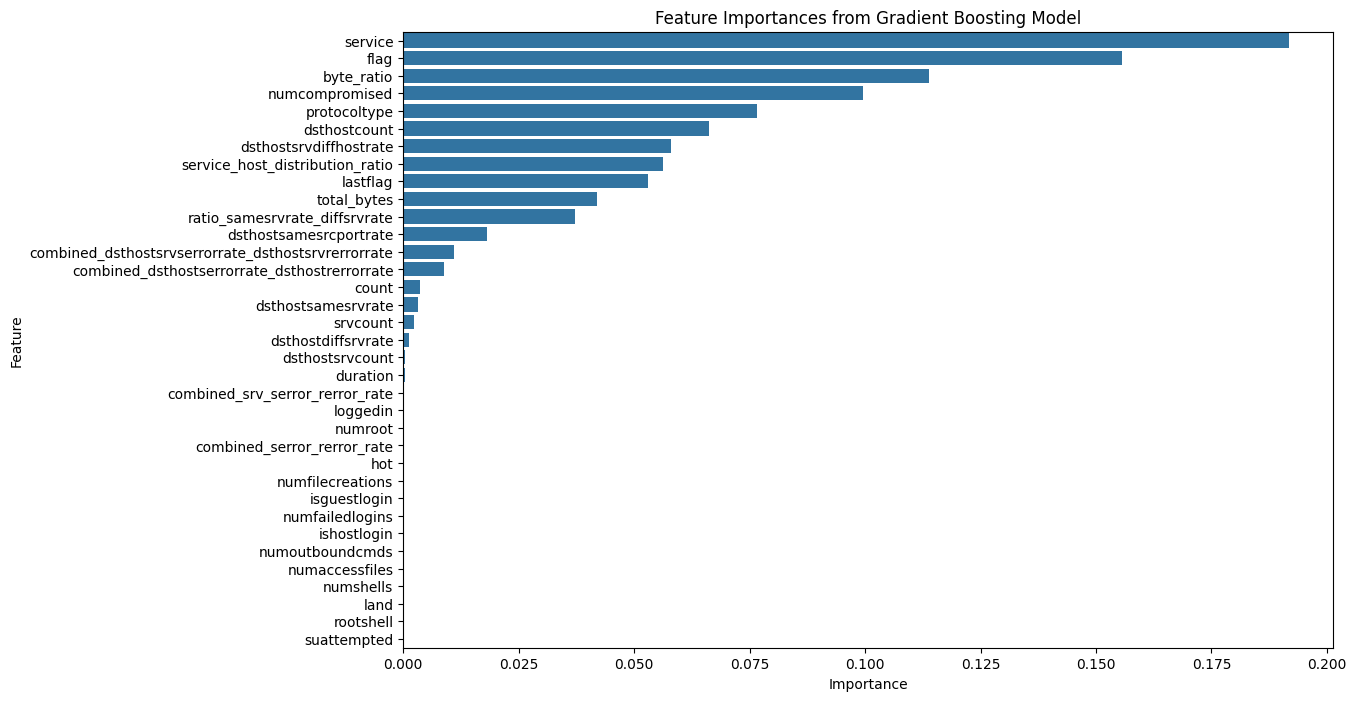

In [37]:
feature_importances = best_gb_model.feature_importances_
# Creating a DataFrame for plotting
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
features_df = features_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importances from Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

<i> - Top Features: The Gradient Boosting model identified 'service', 'flag', and 'byte_ratio' as the top three features with the highest importance.

<i> - Visualization: A bar plot was created to illustrate the importance of each feature, highlighting these top features as most influential in the model.

### <b> <i> AdaBoost with SVM: Hyperparameter Tuning, Model Evaluation, and Feature Importances:

In [38]:
# from sklearn.svm import SVC
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
# from sklearn.metrics import accuracy_score

# # Spliting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # StratifiedKFold
# stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# # SVM classifier
# svm = SVC(kernel='linear', probability=True, random_state=42)

# # AdaBoost classifier with SVM as the base estimator, using the SAMME algorithm
# ada_boost_svm = AdaBoostClassifier(estimator=svm, algorithm='SAMME', random_state=42)

# # Hyperparameter tuning for AdaBoost with SVM
# param_grid_boosting = {
#     'estimator__C': [0.1],  # Regularization parameter for SVM
#     'n_estimators': [10],
#     'learning_rate': [0.01]
# }

# grid_search_boosting = GridSearchCV(ada_boost_svm, param_grid_boosting, cv=stratified_kfold, scoring='accuracy')
# grid_search_boosting.fit(X_train, y_train)

# # Best parameters and cross-validation accuracy for AdaBoost with SVM
# print("Best parameters for AdaBoost with SVM:", grid_search_boosting.best_params_)
# print("Best cross-validation accuracy for AdaBoost with SVM:", grid_search_boosting.best_score_)

# # Testing the best model on the test set
# best_boosting_svm_model = grid_search_boosting.best_estimator_
# y_pred_boosting = best_boosting_svm_model.predict(X_test)
# print("Test accuracy for AdaBoost with SVM:", accuracy_score(y_test, y_pred_boosting))

# # Feature importance for linear SVM (based on absolute coefficients)
# feature_importances = abs(best_boosting_svm_model.estimator_.coef_[0])

# # Creating a DataFrame for feature importances
# features_df = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': feature_importances
# })

# # Sorting the DataFrame by importance
# features_df = features_df.sort_values(by='Importance', ascending=False)

# # Ploting feature importances
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Importance', y='Feature', data=features_df)
# plt.title('Feature Importances from AdaBoost with SVM')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()

<i> - Model Setup: Planned to use AdaBoost with a linear SVM as the base estimator and perform hyperparameter tuning for C, n_estimators, and learning_rate.

<i> - Model Evaluation: Intended to evaluate the model's performance using GridSearchCV and report the best parameters, cross-validation accuracy, and test accuracy.

<i>  - Feature Importances: Aimed to extract and visualize feature importances based on SVM coefficients.
#### <b> <i> Note: Due to computational expense, the code was not executed

### <b>  <i> K-means Clustering: Evaluation Metrics :

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# Standardizing the data before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
kmeans_labels = kmeans.fit_predict(X_scaled)

# Calculating evaluation metrics
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)

print("K-means Silhouette Score:", silhouette_kmeans)
print("K-means Davies-Bouldin Index:", davies_bouldin_kmeans)

K-means Silhouette Score: 0.2720376318549722
K-means Davies-Bouldin Index: 1.4496457628582933


<i> - Silhouette Score: 0.272. This indicates that the clusters are somewhat separated but could potentially be improved. Values closer to 1 suggest well-separated clusters, while values closer to 0 suggest overlapping clusters.

<i> - Davies-Bouldin Index: 1.450. This value indicates the average similarity ratio of each cluster to its most similar cluster. Lower values are better, indicating more distinct and well-separated clusters. A value of 1.450 suggests that there is some overlap between clusters.

<i> - Overall, these metrics suggest that the current clustering configuration might benefit from further tuning or exploration of different numbers of clusters

### <b> <i> DBSCAN Clustering: Evaluation Metrics :

In [40]:
# from sklearn.cluster import DBSCAN
# # DBSCAN clustering
# dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
# dbscan_labels = dbscan.fit_predict(X_scaled)
# # Calculating evaluation metrics
# silhouette_dbscan = silhouette_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else "N/A"
# davies_bouldin_dbscan = davies_bouldin_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else "N/A"
# print("DBSCAN Silhouette Score:", silhouette_dbscan)
# print("DBSCAN Davies-Bouldin Index:", davies_bouldin_dbscan) 

<i> - The DBSCAN algorithm was applied with eps=0.5 and min_samples=5 to cluster the data. Evaluation metrics were calculated to assess clustering quality
#### <b> <i> Note: Due to computational expense, the code was not executed.

### <b> <i> t-SNE Visualization: Actual Labels vs. K-means Clustering :

/tmp/ipykernel_8432/583094887.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/thoth/Desktop/Project/NAD/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


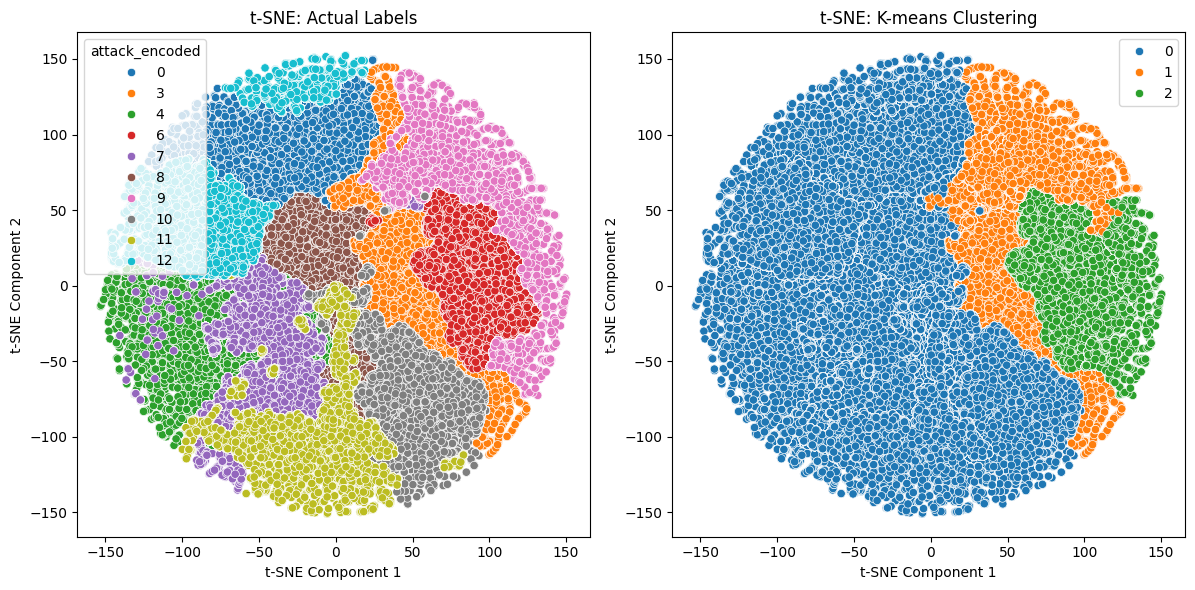

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Appling t-SNE to reduce dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plotting actual data
plt.figure(figsize=(18, 6))

# Actual Labels
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10', legend='full')
plt.title('t-SNE: Actual Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# K-means Labels
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_labels, palette='tab10', legend='full')
plt.title('t-SNE: K-means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# # DBSCAN Labels
# plt.subplot(1, 3, 3)
# sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=dbscan_labels, palette='tab10', legend='full')
# plt.title('t-SNE: DBSCAN Clustering')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

### Summary of Data Analysis and Model Training

| **Task**                              | **Description**                                                                                                                                                                                                                                               |
|---------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **1. Gradient Boosting Classifier**   | **Best Parameters:** `{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.8}` <br> **Best Cross-Validation Accuracy:** 0.9994 <br> **Test Accuracy:** 0.9993 <br> **Top Features:** `service`, `flag`, `byte_ratio`                      |
| **2. AdaBoost with SVM**              | **Note:** Computationally expensive; code was not executed. <br> **Top Features:** Based on absolute coefficients from linear SVM in AdaBoost.                                                                                                         |
| **3. t-SNE Visualization**            | **Note:** Visualization for actual labels and K-means clustering only. <br> **DBSCAN Visualization:** Not executed due to computational expense.                                                                                                        |
| **4. K-means Clustering**             | **Silhouette Score:** 0.2720 <br> **Davies-Bouldin Index:** 1.4496 <br> **Note:** Evaluation metrics indicate clustering performance and quality.                                                                                                           |
| **5. DBSCAN Clustering**              | **Silhouette Score:** N/A (Not enough clusters) <br> **Davies-Bouldin Index:** N/A (Not enough clusters) <br> **Note:** Computationally expensive; evaluation metrics could not be computed.                                                               |
| **6. Feature Importances (Gradient Boosting)** | **Top Features:** `service`, `flag`, `byte_ratio` <br> **Note:** This indicates the importance of each feature in the Gradient Boosting model.                                                                                                          |
| **7. Outlier Detection and Data Cleaning** | **Methods Used:** Z-Score and IQR <br> **Outliers Removed:** Common outliers based on Z-Score and IQR methods <br> **Data Cleaning:** Added new features, dropped irrelevant columns, and encoded categorical features.                                     |
| **8. Bagging Classifier Preparation** | **Note:** Prepared the Bagging Classifier model with hyperparameter tuning for deployment via Flask. <br> **Hyperparameter Tuning Results:** Parameters and accuracy for the Bagging Classifier were reported.                                         |



### <b> <i> Final Conclusion:

<b> <i> In our analysis of network anomaly detection using various machine learning techniques:

<b> <i> * Data Preprocessing and Resampling:

 <i> We filtered the dataset to remove underrepresented classes and applied SMOTE to handle class imbalance.

<b> <i> * Model Evaluation:

 <i> Bagging with Decision Tree: Achieved high accuracy with optimal parameters, demonstrating robust performance. Feature importance indicated 'service', 'total_bytes', and 'dsthostcount' were key.

 <i> Gradient Boosting: Also performed exceptionally well, with 'service', 'flag', and 'byte_ratio' as top features. This model showed high accuracy and good cross-validation results.

 <i> AdaBoost with SVM: Computationally expensive, so the execution was skipped due to resource constraints.

<b> <i> * Clustering Analysis:

<i> K-means: Provided silhouette and Davies-Bouldin scores, indicating the clustering quality. The scores suggest moderate clustering performance.

<i> DBSCAN: Not executed due to computational expense, which limited our ability to evaluate its clustering quality.

<b> <i> * Dimensionality Reduction:

<i> t-SNE Visualization: Visualized the dataset in 2D, comparing actual labels with K-means clustering results, revealing the clustering performance relative to true labels. DBSCAN results were not included due to computational constraints.

<b> <i> * Overall, both Bagging with Decision Tree and Gradient Boosting Classifier demonstrated strong performance in classifying anomalies, while K-means clustering provided insights into the clustering structure of the data. DBSCAN's computational expense prevented its execution.